## 0.1 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

## 0.2 하이퍼파라미터 셋팅

In [2]:
# Hyper-parameters
sequence_length = 28 # 문장의 길이 
input_size = 28 # word embedding vector size
hidden_size = 128 # hidden_state 의 vector size
num_layers = 2 # layer의 갯수 

num_classes = 10
batch_size = 100
num_epochs=2
learning_rate=0.01

In [3]:
#Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. MNIST train. test dataset 가져오기

In [4]:
# MNIST dataset
mnist_train = dset.MNIST("",train=True, transform=transforms.ToTensor(),  # train 용으로 쓰겟다.
                         target_transform=None, download=True)

mnist_test = dset.MNIST("", train=True, transform=transforms.ToTensor(), # test 용으로 쓰겠다.
                        target_transform=None, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 60000
image data 형태:  torch.Size([1, 28, 28])
label: 5


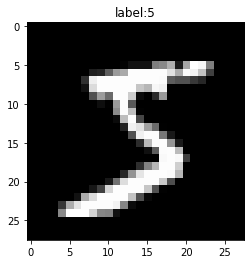

In [5]:
print("mnist_train 길이:", len(mnist_train))
print("mnist_test 길이:", len(mnist_test))

# 데이터 하나 형태 
image, label = mnist_train.__getitem__(0) # 0번째 데이터 
print("image data 형태: ", image.size())
print("label:", label)

# 그리기
img = image.numpy() # image 타입을 numpy 로 변환 (1,28,28)
plt.title("label:%d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

## 3. 데이터 로드 함수
학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [6]:
# Data loaer
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, # mnist_train 을 학습 시키자 
                                           batch_size = batch_size,
                                           shuffle=True, 
                                           drop_last=True)  # batch_size 만큼 나눌 때 나머지는 버려라 

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size = batch_size, 
                                          shuffle=False,   # test 에서는 shuffle 하지 않음
                                          drop_last = True)

## 데이터 로드 함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 100


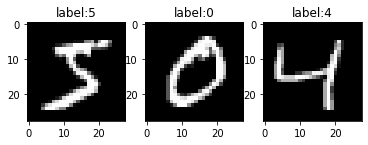

[1]
한 번에 로드되는 데이터 크기: 100


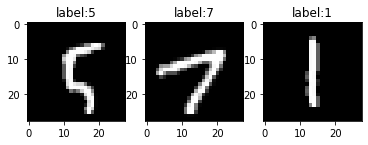

[2]
한 번에 로드되는 데이터 크기: 100


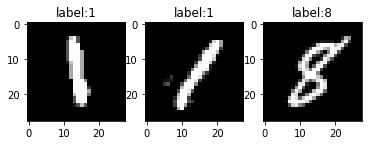

[3]
한 번에 로드되는 데이터 크기: 100


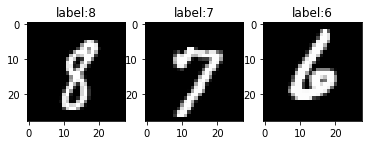

[4]
한 번에 로드되는 데이터 크기: 100


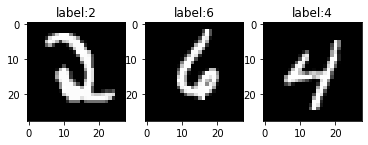

[5]
한 번에 로드되는 데이터 크기: 100


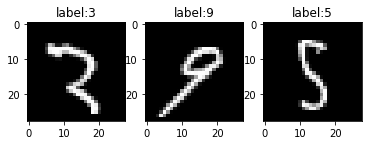

In [7]:
n = 3 # 샘플로 그려볼 데이터 개수 
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i>5:
        break
        
    print("[%d]" %i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))

    # 그리기
    for j in range(n):
        img = imgs[j].numpy()     # image 타입을 numpy 로 변환 (1,28,28)
        img = img.reshape((img.shape[1], img.shape[2])) # (1,28,28) -> (28,28)
        #print img.shape

        plt.subplot(1,n,j+1) #(1,3) 형태 플랏의 j번째 자리에 그리겠다.
        plt.imshow(img, cmap='gray')
        plt.title("label:%d" % labels[j])
    plt.show()

## 4. 모델 선언

In [8]:
#Recurrent neural network(many -to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        #-----
        #input tensor : (batch_size, seq_length, input_size)
        # x :(100,28,28)
        #print('x:', x.shape)

        #-----
        #hidden state tensor :(# of layers, batch_size, hidden_size)
        #h:(2,100,128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # -----
        # Forward porpagate LSTM
        # output tensor: (batch_size, seq_length, hidden_size)
        #out: (100,28,128)
        # print('out:, out.shape)

        out,_ = self.lstm(x,(h0,c0))

        #------
        out = self.fc(out[:,-1,:])

        # y^: (batch_size, num_classes)
        # y_pred : (100,10)
        # print('out:', out.shape)

        return out

In [9]:
model = RNN(input_size, hidden_size, num_layers,num_classes).to(device)

In [10]:
def ComputeAccr(dloader,imodel):
    correct = 0
    total = 0

    for j, [imgs, labels] in enumerate(dloader):
        img = imgs
        img = img.reshape(-1,sequence_length, input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device)

        # Foward prop.
        output = imodel(img) # (batch_size, num_classes)
        _,output_index = torch.max(output,1) # (batch_size, 1)

        total += label.size(0)
        correct += (output_index == label).sum().float()
    return (100*correct/total).numpy() # tensor -> numpy 


In [11]:
print("Accuracy of Test Data: %.2f" % ComputeAccr(test_loader,model))

Accuracy of Test Data: 9.87


## 5. loss, optimizer

In [14]:
# Loss, optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## 6. 학습

In [18]:
#Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        # x:(batch_size,1,seq_length, input_size) -> (batch_size, seq_length, input_size)
        img = imgs
        img = img.reshape(-1,sequence_length,input_size).to(device)

        # y: (batch_size, num_classes)
        label = labels.to(device) # y  #Variable(labels)

        #Forward prop.
        outputs = model(img)
        loss = loss_func(outputs, label)
        
        #Backward prop & optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 ==0:
            print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}, Accr: {:.2f}'
                .format(epoch +1, num_epochs, i+1, total_step,
                            loss.item(),
                            ComputeAccr(test_loader,model)))

Epoch [1/2], Step[100/600], Loss: 0.2496, Accr: 92.12
Epoch [1/2], Step[200/600], Loss: 0.2378, Accr: 94.71
Epoch [1/2], Step[300/600], Loss: 0.2724, Accr: 95.03
Epoch [1/2], Step[400/600], Loss: 0.3279, Accr: 96.56
Epoch [1/2], Step[500/600], Loss: 0.0684, Accr: 96.85
Epoch [1/2], Step[600/600], Loss: 0.1297, Accr: 97.44
Epoch [2/2], Step[100/600], Loss: 0.0570, Accr: 96.75
Epoch [2/2], Step[200/600], Loss: 0.0966, Accr: 97.47
Epoch [2/2], Step[300/600], Loss: 0.0593, Accr: 97.64
Epoch [2/2], Step[400/600], Loss: 0.1232, Accr: 97.76
Epoch [2/2], Step[500/600], Loss: 0.1530, Accr: 97.14
Epoch [2/2], Step[600/600], Loss: 0.0723, Accr: 97.74


## 7. 테스트

In [19]:
print("Accuracy of Test Data:%.2f" % ComputeAccr(test_loader, model))

Accuracy of Test Data:97.74
